In [4]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import moviepy.video.io.ImageSequenceClip

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cpu


In [5]:
import pandas as pd
import numpy as np
df = pd.read_csv('iris.csv')
df.head()

,sepal.length,sepal.width,petal.length,petal.width,variety
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa


In [7]:
target_variable = 'variety'
X = df.drop(columns=[target_variable])
y = df[target_variable]

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_val_np = X_val.to_numpy()
y_val_np = y_val.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_train_encoded_np = y_train_encoded

y_test_encoded = le.fit_transform(y_test)
y_test_encoded_np = y_test_encoded

y_val_encoded = le.fit_transform(y_val)
y_val_encoded_np = y_val_encoded


dataset = {}
dataset['train_input'] = torch.from_numpy(X_train_np).float()
dataset['train_label'] = torch.from_numpy(y_train_encoded_np).long()
dataset['val_input'] = torch.from_numpy(X_val_np).float()
dataset['val_label'] = torch.from_numpy(y_val_encoded_np).long()
dataset['test_input'] = torch.from_numpy(X_test_np).float()
dataset['test_label'] = torch.from_numpy(y_test_encoded_np).long()


Xnew = dataset['train_input']
ynew = dataset['train_label']

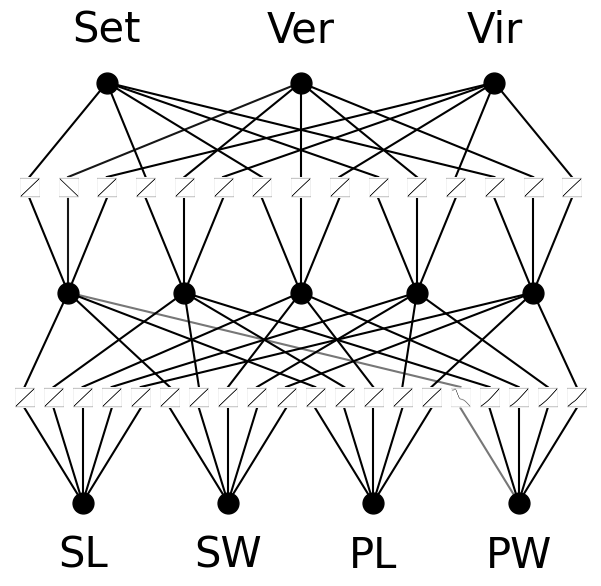

In [14]:
model = KAN(width=[4, 5, 3], grid=5, k=3, seed=42, device=device)
model(dataset['train_input'])
model.plot(beta=50, scale=0.75, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

In [15]:
def train_acc():
    return torch.mean((torch.argmax(model(dataset['train_input']), dim=1) == dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(dataset['test_input']), dim=1) == dataset['test_label']).float())

results = model.train(dataset, opt="Adam", device=device, metrics=(train_acc, test_acc),
                      loss_fn=torch.nn.CrossEntropyLoss(), steps=100, lamb=0.01, lamb_entropy=10)

train loss: 1.55e-01 | test loss: 2.17e-01 | reg: 1.13e+02 : 100%|█| 100/100 [00:08<00:00, 11.59it/s


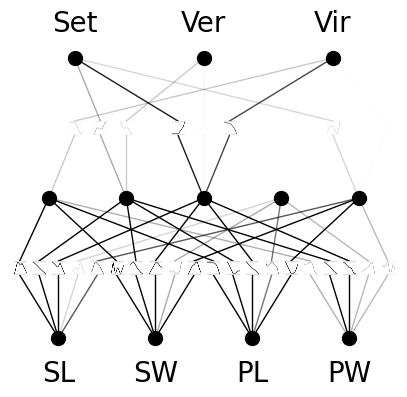

In [16]:
results['train_acc'][-1], results['test_acc'][-1]
model.plot(scale=0.5, in_vars=['SL', 'SW', 'PL', 'PW'], out_vars=['Set', 'Ver', 'Vir'])

Training Set Performance:
Accuracy: 0.9905
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      0.97      0.99        37
           2       0.97      1.00      0.99        37

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105

Confusion Matrix:
[[31  0  0]
 [ 0 36  1]
 [ 0  0 37]]


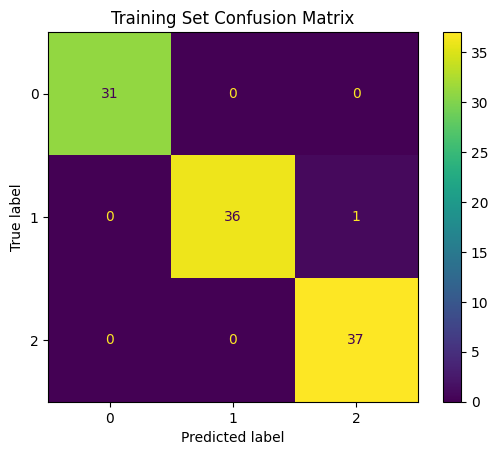

Validation Set Performance:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         6

    accuracy                           1.00        22
   macro avg       1.00      1.00      1.00        22
weighted avg       1.00      1.00      1.00        22

Confusion Matrix:
[[13  0  0]
 [ 0  3  0]
 [ 0  0  6]]


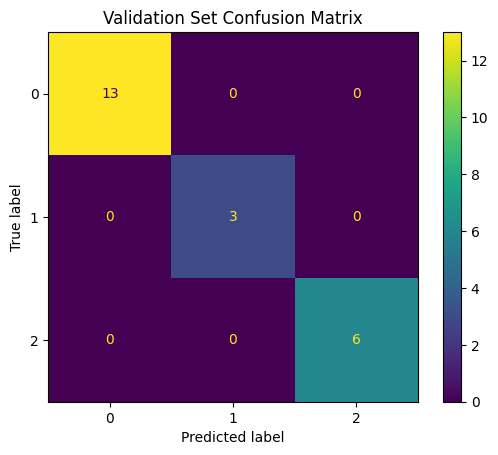

Test Set Performance:
Accuracy: 0.9565
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      0.90      0.95        10
           2       0.88      1.00      0.93         7

    accuracy                           0.96        23
   macro avg       0.96      0.97      0.96        23
weighted avg       0.96      0.96      0.96        23

Confusion Matrix:
[[6 0 0]
 [0 9 1]
 [0 0 7]]


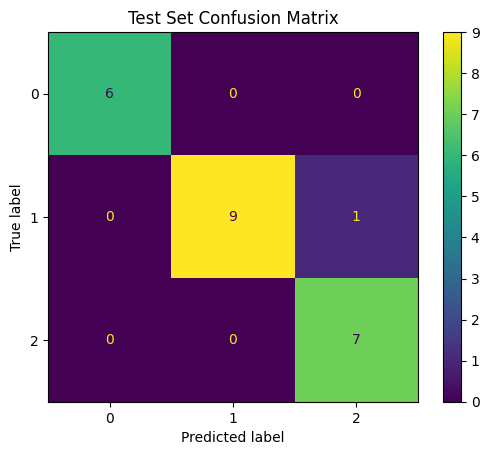

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, dataset):
    # Evaluate on training set
    train_outputs = model(dataset['train_input'])
    train_predictions = torch.argmax(train_outputs, dim=1)
    train_accuracy = accuracy_score(dataset['train_label'].cpu(), train_predictions.cpu())

    print("Training Set Performance:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(dataset['train_label'].cpu(), train_predictions.cpu()))
    print("Confusion Matrix:")
    train_cm = confusion_matrix(dataset['train_label'].cpu(), train_predictions.cpu())
    print(train_cm)
    ConfusionMatrixDisplay(train_cm).plot()
    plt.title('Training Set Confusion Matrix')
    plt.show()

    # Evaluate on validation set
    val_outputs = model(dataset['val_input'])
    val_predictions = torch.argmax(val_outputs, dim=1)
    val_accuracy = accuracy_score(dataset['val_label'].cpu(), val_predictions.cpu())

    print("Validation Set Performance:")
    print(f"Accuracy: {val_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(dataset['val_label'].cpu(), val_predictions.cpu()))
    print("Confusion Matrix:")
    val_cm = confusion_matrix(dataset['val_label'].cpu(), val_predictions.cpu())
    print(val_cm)
    ConfusionMatrixDisplay(val_cm).plot()
    plt.title('Validation Set Confusion Matrix')
    plt.show()

    # Evaluate on test set
    test_outputs = model(dataset['test_input'])
    test_predictions = torch.argmax(test_outputs, dim=1)
    test_accuracy = accuracy_score(dataset['test_label'].cpu(), test_predictions.cpu())

    print("Test Set Performance:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(dataset['test_label'].cpu(), test_predictions.cpu()))
    print("Confusion Matrix:")
    test_cm = confusion_matrix(dataset['test_label'].cpu(), test_predictions.cpu())
    print(test_cm)
    ConfusionMatrixDisplay(test_cm).plot()
    plt.title('Test Set Confusion Matrix')
    plt.show()

# Assuming 'model' is your trained KAN model and 'dataset' contains your data
evaluate_model(model, dataset)
